This is the first notebook I wrote when exploring the amazon dataset. Whilst I have recreated a simplified, cleaned flow in "newEDA.ipynb", I have kept this notebook to show the initial thought process from the earlier sprints. The only change is that any functions written have been moved to "source.py" as I use them in other notebooks too. The outline looks like this:
- imports, read in file
- Data dictionary
- basic cleaning
- EDA: see newEDA notebook to see full extent, including analysis of the Frequency of the vectoriser
- This section also includes comparison of three different Amazon review categories, to show that the rating distribution favours the "5" class in many cases, leading me to chose the technology category.
- Text vectorisation (preprocessing)
- Frequency analysis
- Basic logistic model 

In [56]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# modelling
from sklearn.linear_model import LogisticRegression
# source file (custom functions)
from source import getDF, simplifyReviews, rating_distribution, bow_review

In [3]:
# reading in the file
df = getDF('../data/Cell_Phones_and_Accessories_5.json.gz')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128437 entries, 0 to 1128436
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1128437 non-null  float64
 1   verified        1128437 non-null  bool   
 2   reviewTime      1128437 non-null  object 
 3   reviewerID      1128437 non-null  object 
 4   asin            1128437 non-null  object 
 5   style           605241 non-null   object 
 6   reviewerName    1128302 non-null  object 
 7   reviewText      1127672 non-null  object 
 8   summary         1127920 non-null  object 
 9   unixReviewTime  1128437 non-null  int64  
 10  vote            92034 non-null    object 
 11  image           27107 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 104.4+ MB


We see that we have 12 columns in total. We have the star review, whether the review is verified, the review time, ID of reviewer, some keys to link to the product data, the name of the reviewer, the actual text review, the summary review as well as whether their review was marked as helpful, and some images of the product. 

## Data Dictionary

| Column name    | Datatype | Measures| Notes|
| -------------- | -------- | ---------------------------------------------------- | --------------------------------------- |
| overall        | float    | Overall star rating of review   |                                         |
| verified       | boolean  | Whether the review has been verified as real or not. | |
| reviewTime     | object   | Time of review    | If needed can change type to datetime64 |
| reviewerID     | object   | Unique ID of reviewer                                |                                         |
| asin           | object   | Product metadata  |Amazon Standard Identification Number|
| style          | object   | Product metadata                                     |                                         |
| reviewerName   | object   | Name of reviewer                                     |                                         |
| reviewText     | object   | Textual contents of review                           |                                         |
| summary        | object   | Textual summary of review                            |                                         |
| unixReviewTime | int64    | Time of review since Unix Epoch on January 1st, 1970 |                                         |
| vote           | object   | Count of usefulness vote                             |                                         |
| image          | object   | Image of product reviewed                            |                                         |

In [5]:
# checking for null values, rows with no reviews are not useful 
df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              523196
reviewerName          135
reviewText            765
summary               517
unixReviewTime          0
vote              1036403
image             1101330
dtype: int64

In [6]:
(df.isna().sum())/(df.shape[0])

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
style             0.463647
reviewerName      0.000120
reviewText        0.000678
summary           0.000458
unixReviewTime    0.000000
vote              0.918441
image             0.975978
dtype: float64

We see that we have nulls for some reviews as well as other metadata. These will not be helpful for us

In [7]:
df[['overall']].value_counts(normalize=True)

overall
5.0        0.626564
4.0        0.163439
3.0        0.087071
1.0        0.072258
2.0        0.050667
Name: proportion, dtype: float64

In [8]:
df['verified'].value_counts(normalize=True)

verified
True     0.874948
False    0.125052
Name: proportion, dtype: float64

we only want verified reviews:

"After someone submits a review, we check if they:

Bought or used the item on Amazon;
Paid a price available to most Amazon shoppers.
If we confirm both, we label the review as Verified Purchase."

In [9]:
len(df["asin"].unique())

48186

In [10]:
df["asin"].value_counts()[:10]

asin
B00VH88CJ0    1684
B005NF5NTK    1634
B00X5RV14Y    1514
B00P7N0320    1513
B019PV2I3G    1508
B018JW3EOY    1506
B00G7UY3EG    1378
B00MQSMDYU    1340
B00M51DDT2    1267
B00QN1T6NM    1228
Name: count, dtype: int64

In [33]:
# df1 = pd.read_csv("../data/clean_technology_reviews.csv")
# we have already loaded in the technology reviews

Loading in some other catagories to compare the rating distribution

In [34]:
df2 = getDF("../data/Office_Products_5.json.gz")


In [35]:
df3 = getDF("../data/Toys_and_Games_5.json.gz")


Lets make a simplified version of our data containing only rating and text review and summary, including only the verified reviews containing textual data, using the simplifyReviews function from the source file

In [36]:
tech_simple = simplifyReviews(df)
office_simple = simplifyReviews(df2)
toys_simple = simplifyReviews(df3)

<class 'pandas.core.frame.DataFrame'>
Index: 987324 entries, 0 to 1128436
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     987324 non-null  float64
 1   reviewText  986589 non-null  object 
 2   asin        987324 non-null  object 
dtypes: float64(1), object(2)
memory usage: 30.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 710187 entries, 0 to 800356
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     710187 non-null  float64
 1   reviewText  709987 non-null  object 
 2   asin        710187 non-null  object 
dtypes: float64(1), object(2)
memory usage: 21.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1599831 entries, 0 to 1828970
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   overall     1599831 non-null  float64
 1   reviewText  1598728 no

In [37]:
tech_simple.duplicated().sum()

0

In [38]:
# once made as csvs can use these instead:
df1 = pd.read_csv("../data/clean_technology_reviews.csv")

In [39]:
df1.duplicated().sum()

0

In [40]:
# df2 = pd.read_csv("../data/clean_office_reviews.csv")


In [41]:
# df3 = getDF("Toys_and_Games_5.json.gz")


In [42]:
tech_simple.sample(5)

,overall,reviewText,asin
541628,1.0,Too thick and caused touch screen issues. I wo...,B00PXEFYAO
630176,5.0,Works with no issues on AT&T LG G4 H810. Simpl...,B00WIMGAVG
78018,5.0,This is the perfect portable stand for a smart...,B0065UYJP6
671550,5.0,Bought this case for my boyfriend and he loves...,B00ZYTXLSK
302317,2.0,do not buy this charger. It is not worth the m...,B00GV0RIGW


We can read in the data from these csvs in future.
We will analyze the rating distributions of three specific Amazon product categories. We've selected these particular categories because their reviews more accurately reflect sentiments about the actual products, as opposed to categories like books or video games, where reviews might primarily address the content rather than the product itself.

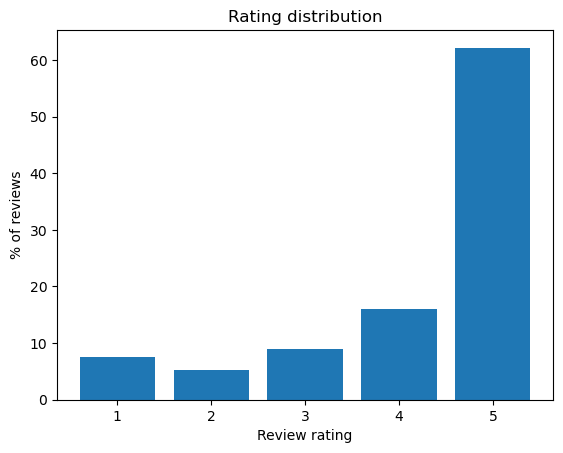

array([0.07526079, 0.05257072, 0.08971679, 0.16078931, 0.62166237])

In [43]:
rating_distribution(tech_simple)

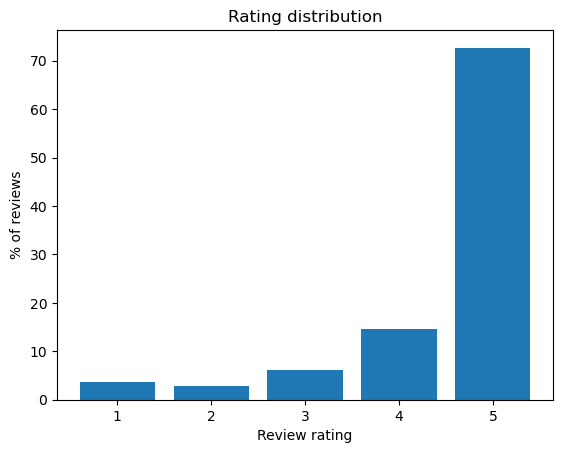

array([0.0368593 , 0.02892534, 0.06153176, 0.14606002, 0.72662357])

In [44]:
rating_distribution(office_simple)

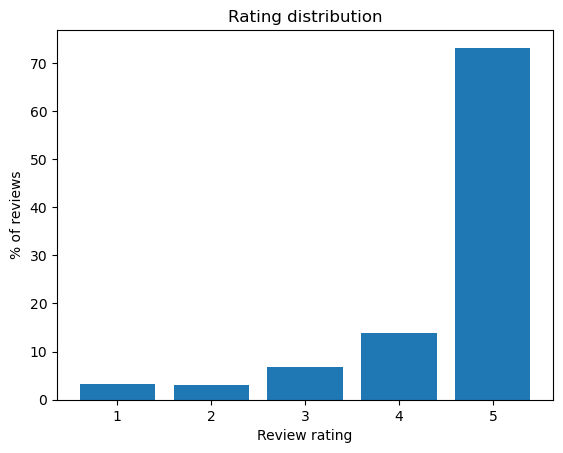

array([0.03185056, 0.02995291, 0.06821187, 0.13866771, 0.73131694])

In [45]:
rating_distribution(toys_simple)

In [46]:
pd.DataFrame(np.unique(tech_simple['overall'], return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,73423.0,51287.0,87526.0,156863.0,606482.0


In [47]:
pd.DataFrame(np.unique(office_simple['overall'], return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,24302.0,19071.0,40569.0,96300.0,479076.0


In [48]:
pd.DataFrame(np.unique(toys_simple['overall'], return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,48926.0,46011.0,104781.0,213009.0,1123384.0


We see that the majority of the reviews are 5 stars, in the tech reviews, "only" 62% are 5 star, so I will use this as it is lowest. For modelling, we will need to come back and address this issue later 

In [49]:
tech_simple.head(5)

,overall,reviewText,asin
0,5.0,Looks even better in person. Be careful to not...,7508492919
1,5.0,When you don't want to spend a whole lot of ca...,7508492919
2,3.0,"so the case came on time, i love the design. I...",7508492919
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,7508492919
4,4.0,"I liked it because it was cute, but the studs ...",7508492919


It will be useful to know the length of a review

In [50]:
rev_len = list()
for review in tech_simple["reviewText"]:
    rev_len.append(len(review))

In [51]:
tech_simple["length"] = rev_len

In [52]:
tech_simple["length"].describe()

count    975581.000000
mean        210.164239
std         363.319923
min           1.000000
25%          35.000000
50%         110.000000
75%         241.000000
max       33457.000000
Name: length, dtype: float64

In [54]:
# Save these as parquet files now we have added length to tech_simple
tech_simple.to_parquet("../data/clean_technology_reviews.parquet")
office_simple.to_parquet("../data/clean_office_reviews.parquet")
toys_simple.to_parquet("../data/clean_toys_reviews.parquet")

We see that most reviews are between 34 and 240 characters long with a max of 33,457. We will probably not be able to analyse full essays but it will be useful before eliminating any to see if there is a relationship between review length and overall star rating 

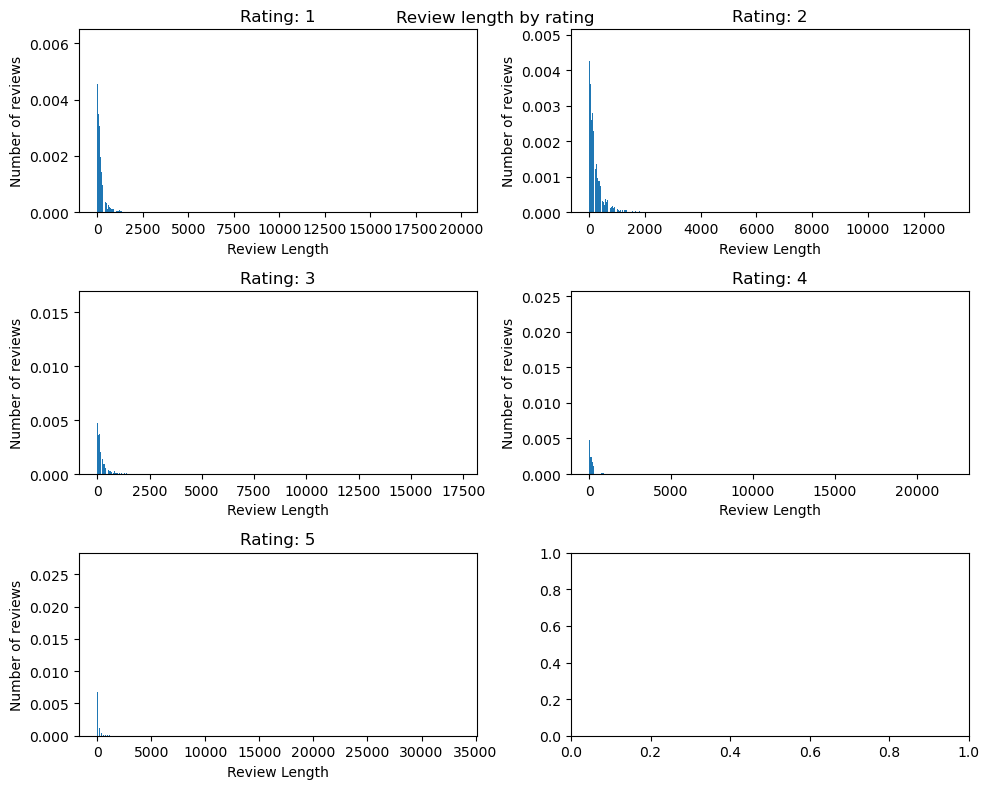

In [55]:
plt.subplots(3,2, figsize=(10,8))
for i in range(1,6):
    len_dist = tech_simple["length"][tech_simple["overall"]==i].value_counts().reset_index()
    len_dist['count_norm']=len_dist['count']/len_dist["count"].sum()
    plt.subplot(3,2,i)
    # plt.bar(len_dist["length"],len_dist['count'])
    plt.bar(len_dist["length"],len_dist['count_norm'])
    plt.title(f"Rating: {i}")
    plt.xlabel("Review Length")
    plt.ylabel("Number of reviews")
plt.tight_layout()
plt.suptitle("Review length by rating")

plt.show()

It is clear we should remove the absolute outliers

In [109]:
tech_simple2 = tech_simple[tech_simple["length"]<=2500].copy()


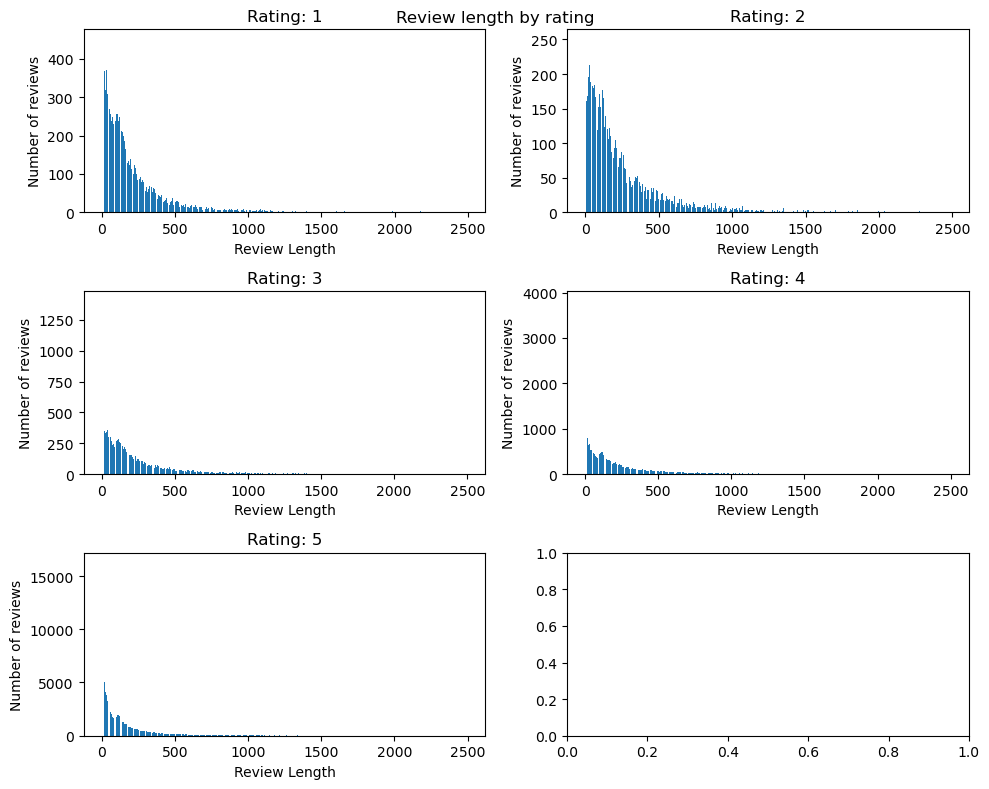

In [110]:
import seaborn as sns
plt.subplots(3,2, figsize=(10,8))
for i in range(1,6):
    len_dist = tech_simple2["length"][tech_simple2["overall"]==i].value_counts().reset_index()
    len_dist['count_norm']=len_dist['count']/len_dist["count"].sum()
    plt.subplot(3,2,i)
    plt.bar(len_dist["length"],len_dist['count'])
    # plt.bar(len_dist["length"],len_dist['count_norm'])
    plt.title(f"Rating: {i}")
    plt.xlabel("Review Length")
    plt.ylabel("Number of reviews")
plt.tight_layout()
plt.suptitle("Review length by rating")

plt.show()

Lets look at how the distribution changes as we reduce total length to 500 characters 

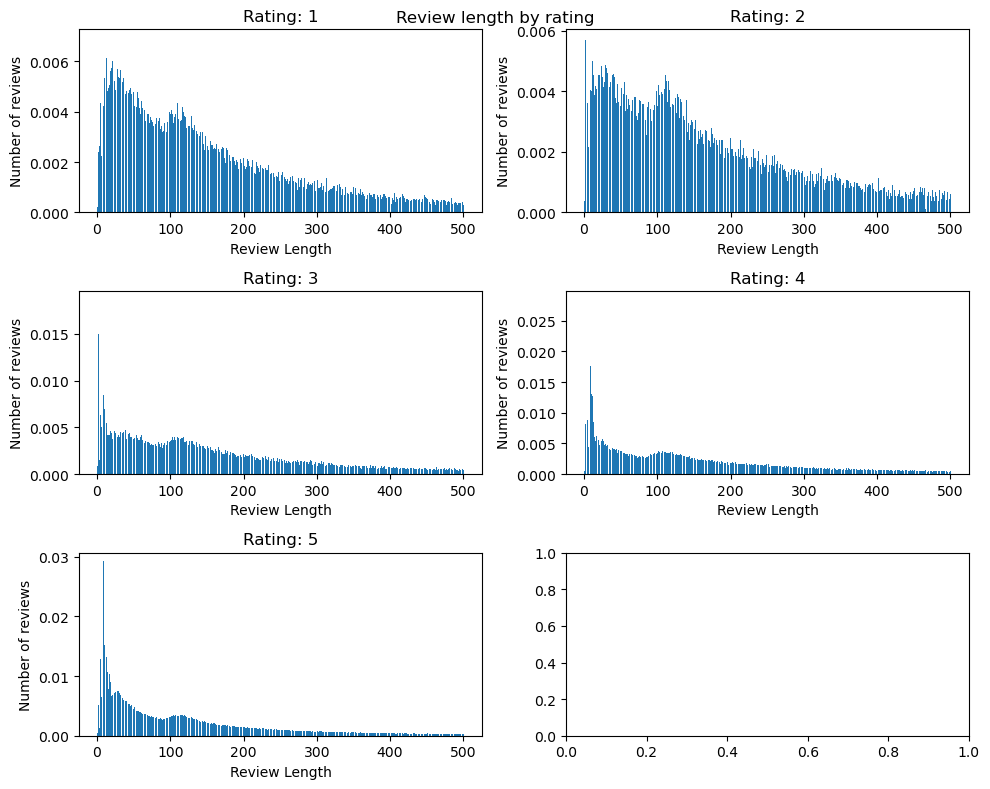

In [107]:
tech_simple3 = tech_simple[tech_simple["length"]<=500].copy()

plt.subplots(3,2, figsize=(10,8))
for i in range(1,6):
    len_dist = tech_simple3["length"][tech_simple3["overall"]==i].value_counts().reset_index()
    len_dist['count_norm']=len_dist['count']/len_dist["count"].sum()
    plt.subplot(3,2,i)
    # plt.bar(len_dist["length"],len_dist['count'])
    plt.bar(len_dist["length"],len_dist['count_norm'])
    plt.title(f"Rating: {i}")
    plt.xlabel("Review Length")
    plt.ylabel("Number of reviews")
plt.tight_layout()
plt.suptitle("Review length by rating")
plt.show()

Ignoring the outliers, the length of reviews seems to follow the same distribution overall regardless of rating. It is important to remember the vast majority of reviews are 5 stars, and we will need to eventually account for this bias in the data when modelling. 

In [50]:
short_car = tech_simple3.copy()


In [51]:
short_car.sample()

,overall,reviewText,asin,length
865760,5.0,"Super cute, and good quality, protect my phone...",B01FRBDZGC,57


In [52]:
l_values, l_counts = np.unique(short_car['length'], return_counts=True)

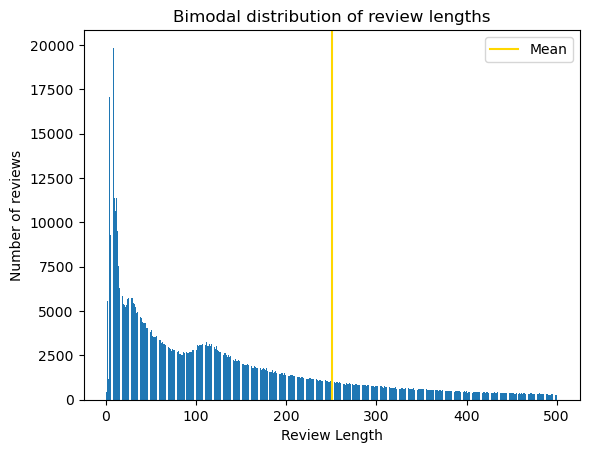

In [114]:
plt.figure()
plt.bar(l_values, l_counts)
plt.axvline(l_values.mean(), color='gold', label="Mean")

plt.xlabel("Review Length")
plt.ylabel("Number of reviews")
plt.title("Bimodal distribution of review lengths")
plt.legend()
plt.show()

## First attempt at vectorising the text
We have not removed stop words etc and we also have many many spelling mistakes. I will show the full extent then for a first pass remove any tokens not in the english language.

In [56]:
short_car['reviewText'] = short_car['reviewText'].str.lower()


In [61]:
short_car["reviewText"][:3]

0    looks even better in person. be careful to not...
1    when you don't want to spend a whole lot of ca...
2    so the case came on time, i love the design. i...
Name: reviewText, dtype: object

In [78]:
# Test train split, also will change {1,2,3}->0, {4,5}->1, subject to change
X_1 = short_car["reviewText"].copy()
y_1= np.where(short_car['overall']>3, 1, 0)


X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [79]:
# using Bagofwords model to vectorise words, in the end I will use TF-IDF
bow1, doc_term_train_1, doc_term_test_1 = bow_review(X_train, X_test)

In [80]:
# these are now the features, they are the individual tokens
# bagofwords.get_feature_names()

bow1.get_feature_names_out()
corpus1 = bow1.get_feature_names_out()


print(doc_term_train_1.shape[0] * doc_term_train_1.shape[1] * doc_term_train_1.dtype.itemsize / 1e6)
print(doc_term_train_1.shape)

355557.476336
(704342, 63101)


In [81]:
term_frequencies = doc_term_train_1.sum(axis=0)
term_frequencies.shape

(1, 63101)

In [82]:
corpus1[53200:]

array(['straps', 'strarting', 'strat', ..., 'zzzzzzz', 'zzzzzzzz',
       'zzzzzzzzz'], dtype=object)

Lets understand tokens with spelling mistakes:, we can remove them and see the difference in the tokenisation, note that this would normally happen by selecting max features

In [86]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /Users/edo/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [87]:
english_words = set(nltk.corpus.words.words())
unrecognized_tokens = [token for token in corpus1 if token.lower() not in english_words]
num_unrec = len(unrecognized_tokens)
num_unrec/len(corpus1)

0.7261691573826088

In [88]:
short_car2 = short_car.copy()
short_car2['reviewText'] = short_car2['reviewText'].apply(lambda x: ' '.join(word for word in x.split() if word in english_words))
short_car2

,overall,reviewText,asin,length
0,5.0,even better in be careful to not drop your pho...,7508492919,271
1,5.0,when you want to spend a whole lot of cash but...,7508492919,102
2,3.0,so the case came on i love the actually missin...,7508492919,257
3,2.0,care for gave it as a gift and they were with ...,7508492919,92
4,4.0,i it because it was but the fall off easily an...,7508492919,150
...,...,...,...,...
975576,4.0,very good cell phone my phone in yet is fairly,B01HJBS5C2,79
975577,1.0,mediocre case clip is on,B01HJBS5C2,62
975578,3.0,my sons for the price it too bad,B01HJC7N4C,48
975579,4.0,good for but have a button or controller for h...,B01HJC7N4C,142


In [89]:
short_car2.to_csv("../data/bag_of_words_Raw1.csv")

And again:

In [94]:
X_2 = short_car2["reviewText"].copy()
y_2= np.where(short_car2['overall']>3, 1, 0)


X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [95]:
bow2, doc_term_train_2, doc_term_test_2 = bow_review(X_train2,X_test2, stop="english")

In [96]:
bow2.get_feature_names_out()
corpus2 = bow2.get_feature_names_out()

# small_transformed.toarray()
print(doc_term_train_2.shape[0] * doc_term_train_2.shape[1] * doc_term_train_2.dtype.itemsize / 1e6)
print(doc_term_train_2.shape)

88887.9604
(704342, 15775)


In [97]:
corpus2[:10]

array(['aa', 'aam', 'aback', 'abacus', 'abandon', 'abandoned',
       'aberration', 'abet', 'abhor', 'abide'], dtype=object)

It looks like we have removed the non-english words. This is good for a first pass, however we will need to return and address the issue of spelling mistakes in future.

Now, we can get the term term frequencies for each token in our corpus

In [98]:
# sometimes this block kills the kernel
term_frequencies2 = doc_term_train_2.sum(axis=0)
print(term_frequencies2.shape)
print(len(corpus2))
print(term_frequencies2[:][:1])
# my_df = pd.DataFrame(columns=bow2.get_feature_names(), data=doc_term_train_2.toarray())

my_df = pd.DataFrame.sparse.from_spmatrix(columns=bow2.get_feature_names_out(), data=doc_term_train_2)


(1, 15775)
15775
[[ 50   1   7 ...  41   3 132]]


In [99]:
my_df.head()

,aa,aam,aback,abacus,abandon,abandoned,aberration,abet,abhor,abide,...,zipper,zipping,zippy,zircon,zo,zodiac,zombie,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
freq_df = pd.DataFrame(columns=bow2.get_feature_names_out(), data=term_frequencies2)
freq_df = freq_df.T.sort_values(0, ascending=False)
freq_df.head(20)

,0
phone,173764
case,155044
great,137370
good,107423
like,82403
love,76882
works,72681
screen,69939
just,65531
nice,51912


In [101]:
total_obs = freq_df[0].sum()
total_obs

4904365

# Modelling
This is just to see what is possible, much more indepth modelling is done in other notebooks, highlighted in the notebook README.md file

the communicaiton will be there, but to summarise, here I fit a logistic regression with $l2$ penalty.
then I show the train/test scores and show the top words influencing pos/negative reviews

In [121]:
# Fitting a model

logreg = LogisticRegression(C = 0.1, max_iter=1000, random_state=12)
logreg.fit(doc_term_train_2, y_train2)

# Training and test score
print(f"Train score: {logreg.score(doc_term_train_2, y_train2)}")
print(f"Test score: {logreg.score(doc_term_test_2, y_test2)}")



Train score: 0.8583628407790533
Test score: 0.8559624274502232


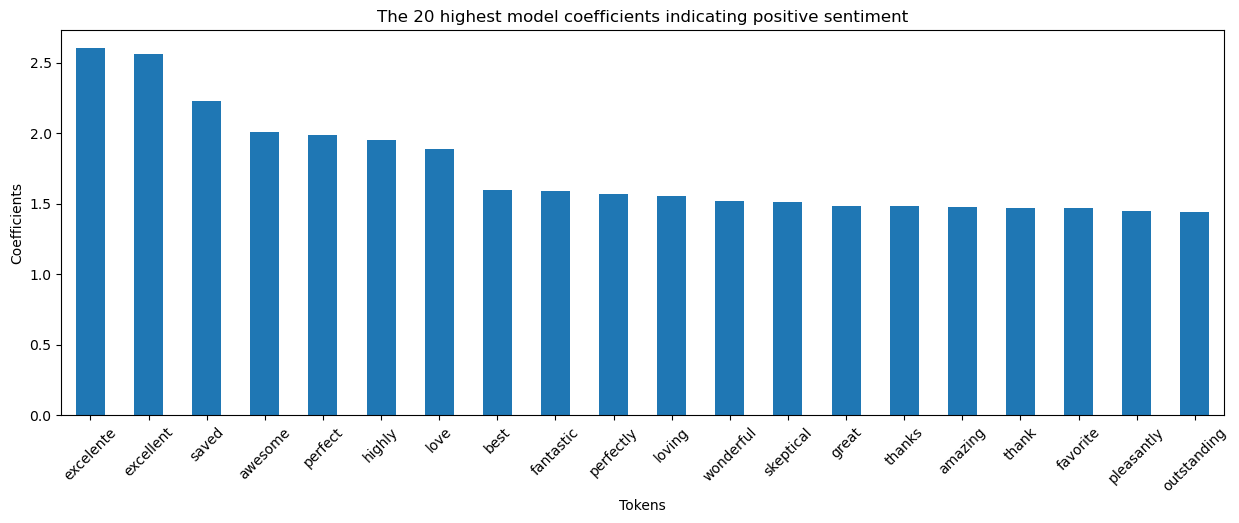

In [123]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bow2.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.xlabel("Tokens")
plt.show()

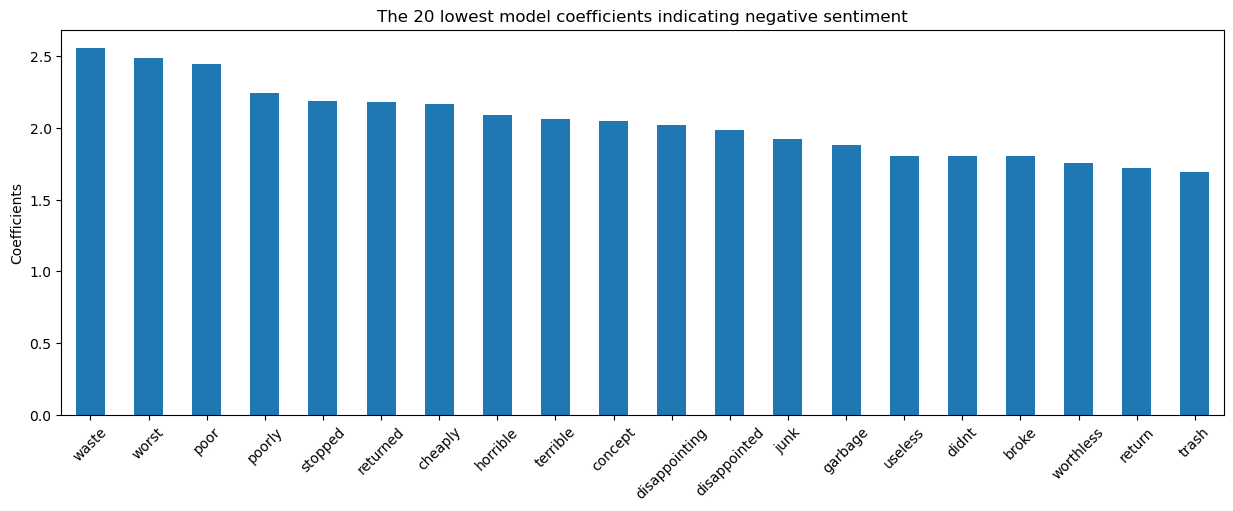

In [124]:
word_counts.sort_values("coefficients", ascending=True).head(20).abs().plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# bow3, doc_term_train_3, doc_term_test_3 = bow_review(X_train2,X_test2, stop="english", ngrams=(1,3))

In [ ]:
# bow3.get_feature_names()
# corpus3 = bow3.get_feature_names()

# # small_transformed.toarray()
# print(doc_term_train_3.shape[0] * doc_term_train_3.shape[1] * doc_term_train_3.dtype.itemsize / 1e6)
# print(doc_term_train_3.shape)

In [ ]:
# # Fitting a model
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression(C = 0.1, max_iter=1000)
# logreg.fit(doc_term_train_3, y_train2)

# # Training and test score
# print(f"Train score: {logreg.score(doc_term_train_3, y_train2)}")
# print(f"Test score: {logreg.score(doc_term_test_3, y_test2)}")

